# GAN Training - Camel Dataset

This notebook trains a Generative Adversarial Network (GAN) on the Camel
dataset (Quick, Draw!) to generate hand-drawn camel sketches.

## Features

- **Dynamic Configuration**: Batch size and epochs adjust based on GPU VRAM
- **W&B Integration**: Full experiment tracking with Weights & Biases
- **LR Scheduling**: Step decay learning rate for stable training
- **Enhanced Visualization**: Loss, accuracy, and LR history plots

## Architecture

- **Discriminator**: 4-layer CNN with strided convolutions
- **Generator**: 4-layer deconvolution network with upsampling

## References

- Goodfellow et al. "Generative Adversarial Networks" (2014)
- Chapter 4 of "Generative Deep Learning" book

## GPU Memory Setup

Configure TensorFlow to use memory growth, preventing OOM errors.

In [1]:
# =============================================================================
# GPU MEMORY CONFIGURATION
# =============================================================================
# Enable memory growth to prevent TensorFlow from allocating all GPU memory
# at once. This must be done BEFORE any other TensorFlow operations.

import tensorflow as tf

# Get list of available GPUs
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    # Enable memory growth for each GPU
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"✓ GPU(s) available: {[gpu.name for gpu in gpus]}")
else:
    print("⚠ WARNING: No GPU detected, running on CPU")

2026-01-02 15:33:00.838884: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


✓ GPU(s) available: ['/physical_device:GPU:0']


## Imports

Import all required modules including project utilities.

In [2]:
# =============================================================================
# IMPORTS
# =============================================================================

# -----------------------------------------------------------------------------
# Path Configuration
# -----------------------------------------------------------------------------
# Add parent directories to path for importing project modules
# - '..' gives access to v1/src modules
# - '../..' gives access to project root utils/ directory
import sys
sys.path.insert(0, '..')      # For v1/src modules
sys.path.insert(0, '../..')   # For project root utils/

# -----------------------------------------------------------------------------
# Standard Library
# -----------------------------------------------------------------------------
import os

# -----------------------------------------------------------------------------
# Third-Party Libraries
# -----------------------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import wandb

# -----------------------------------------------------------------------------
# Project Modules
# -----------------------------------------------------------------------------
from src.models.GAN import GAN
from src.utils.loaders import load_safari

# GPU utilities for dynamic batch size and epoch scaling
# Located in project root: utils/gpu_utils.py
from utils.gpu_utils import (
    get_optimal_batch_size,
    calculate_adjusted_epochs,
    get_gpu_vram_gb,
    print_training_config
)

## Global Configuration

Central configuration cell with all training hyperparameters.
Batch size and epochs are automatically optimized based on GPU VRAM.

In [3]:
# =============================================================================
# GLOBAL CONFIGURATION
# =============================================================================

# -----------------------------------------------------------------------------
# Run Identification
# -----------------------------------------------------------------------------
SECTION = 'gan'
RUN_ID = '0001'
DATA_NAME = 'camel'
RUN_FOLDER = f'../run/{SECTION}/{RUN_ID}_{DATA_NAME}'

# -----------------------------------------------------------------------------
# Create Run Directories
# -----------------------------------------------------------------------------
if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.makedirs(os.path.join(RUN_FOLDER, 'viz'))
    os.makedirs(os.path.join(RUN_FOLDER, 'images'))
    os.makedirs(os.path.join(RUN_FOLDER, 'weights'))

# -----------------------------------------------------------------------------
# Reference Training Configuration
# These are the original notebook values used as baseline
# -----------------------------------------------------------------------------
REFERENCE_BATCH_SIZE = 256
REFERENCE_EPOCHS = 6000

# -----------------------------------------------------------------------------
# Dynamic Training Configuration
# Automatically optimized based on available GPU VRAM
# -----------------------------------------------------------------------------

# VRAM Override: Set to specific value (e.g., 8) or None for auto-detection
# Use this when you want to force a specific configuration
TARGET_VRAM_GB = None  # Options: None, 6, 8, 12, 16, 24

# Detect GPU VRAM or use manual override
GPU_VRAM_GB = TARGET_VRAM_GB if TARGET_VRAM_GB else get_gpu_vram_gb()

# Calculate optimal batch size for detected VRAM
# Larger VRAM = larger batch size = faster training
BATCH_SIZE = get_optimal_batch_size('gan', vram_gb=GPU_VRAM_GB)

# Scale epochs to maintain equivalent total training updates
# Formula: reference_epochs × (reference_batch / actual_batch)
EPOCHS = calculate_adjusted_epochs(
    REFERENCE_EPOCHS,
    REFERENCE_BATCH_SIZE,
    BATCH_SIZE
)

# Adjust checkpoint frequency proportionally
PRINT_EVERY_N_BATCHES = max(50 * REFERENCE_BATCH_SIZE // BATCH_SIZE, 10)

# -----------------------------------------------------------------------------
# Learning Rate Scheduler Configuration
# Step decay: Reduce LR at fixed intervals for stable late-stage training
# -----------------------------------------------------------------------------
LR_DECAY_FACTOR = 0.5  # Multiply LR by this factor at each decay point
LR_DECAY_EPOCHS = EPOCHS // 4  # Decay 4 times during training

# -----------------------------------------------------------------------------
# Training Mode
# -----------------------------------------------------------------------------
MODE = 'build'  # Options: 'build' (new training), 'load' (resume from weights)

# -----------------------------------------------------------------------------
# Print Configuration Summary
# -----------------------------------------------------------------------------
print_training_config(
    'gan',
    BATCH_SIZE,
    EPOCHS,
    REFERENCE_BATCH_SIZE,
    REFERENCE_EPOCHS,
    GPU_VRAM_GB
)
print(f"LR Decay: ×{LR_DECAY_FACTOR} every {LR_DECAY_EPOCHS} epochs")
print(f"Checkpoints: Every {PRINT_EVERY_N_BATCHES} epochs")

════════════════════════════════════════════════════════════════════
TRAINING CONFIGURATION
════════════════════════════════════════════════════════════════════
Model Type:     GAN
GPU VRAM:       8 GB
Batch Size:     1024 (reference: 256)
Epochs:         1500 (reference: 6000)
Scale Factor:   0.25x epochs
════════════════════════════════════════════════════════════════════
LR Decay: ×0.5 every 375 epochs
Checkpoints: Every 12 epochs


I0000 00:00:1767367992.286248   59894 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6094 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


## Data Loading

Load the Camel dataset from Quick, Draw! collection.

In [4]:
# =============================================================================
# DATA LOADING
# =============================================================================
# Load the camel dataset from the Quick, Draw! collection
# Images are 28x28 grayscale drawings

(x_train, y_train) = load_safari(DATA_NAME)

# Print dataset information
print(f"Dataset: {DATA_NAME}")
print(f"Training samples: {x_train.shape[0]:,}")
print(f"Image dimensions: {x_train.shape[1:]}")
print(f"Data type: {x_train.dtype}")
print(f"Value range: [{x_train.min():.2f}, {x_train.max():.2f}]")

Dataset: camel
Training samples: 80,000
Image dimensions: (28, 28, 1)
Data type: float32
Value range: [-1.00, 1.00]


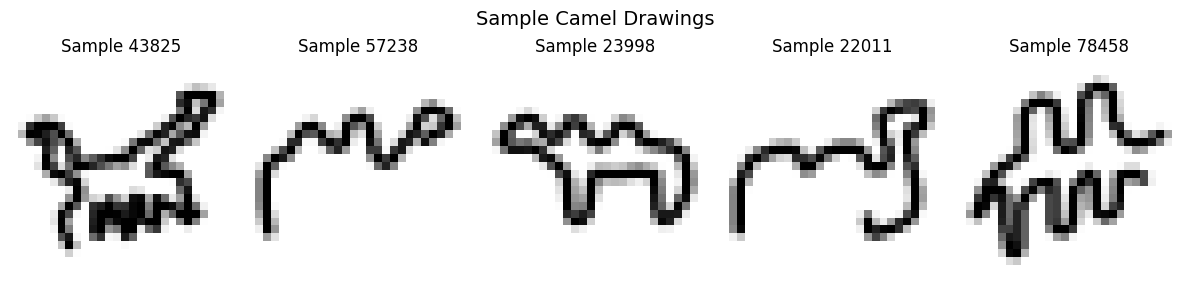

In [5]:
# =============================================================================
# SAMPLE VISUALIZATION
# =============================================================================
# Display a sample image from the dataset

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle('Sample Camel Drawings', fontsize=14)

for i, ax in enumerate(axes):
    idx = np.random.randint(0, x_train.shape[0])
    ax.imshow(x_train[idx, :, :, 0], cmap='gray_r')
    ax.axis('off')
    ax.set_title(f'Sample {idx}')

plt.tight_layout()
plt.show()

## Model Architecture

Build the GAN with discriminator and generator networks.

In [6]:
# =============================================================================
# MODEL ARCHITECTURE
# =============================================================================
# Build the GAN with configurable discriminator and generator
#
# Discriminator Architecture:
#   Input (28, 28, 1) → Conv layers → Flatten → Dense(1, sigmoid)
#
# Generator Architecture:
#   Input (z_dim,) → Dense → Reshape → ConvTranspose layers → Output (28, 28, 1)

gan = GAN(
    # -------------------------------------------------------------------------
    # Input Configuration
    # -------------------------------------------------------------------------
    input_dim=(28, 28, 1),  # 28x28 grayscale images
    z_dim=100,              # Latent space dimension
    
    # -------------------------------------------------------------------------
    # Discriminator Configuration
    # 4 convolutional layers with increasing filters
    # -------------------------------------------------------------------------
    discriminator_conv_filters=[64, 64, 128, 128],
    discriminator_conv_kernel_size=[5, 5, 5, 5],
    discriminator_conv_strides=[2, 2, 2, 1],
    discriminator_batch_norm_momentum=None,  # No batch norm in discriminator
    discriminator_activation='relu',
    discriminator_dropout_rate=0.4,
    discriminator_learning_rate=0.0008,
    
    # -------------------------------------------------------------------------
    # Generator Configuration
    # 4 upsampling layers to generate 28x28 output
    # -------------------------------------------------------------------------
    generator_initial_dense_layer_size=(7, 7, 64),  # Start from 7x7
    generator_upsample=[2, 2, 1, 1],  # Upsample to 14x14, then 28x28
    generator_conv_filters=[128, 64, 64, 1],
    generator_conv_kernel_size=[5, 5, 5, 5],
    generator_conv_strides=[1, 1, 1, 1],
    generator_batch_norm_momentum=0.9,
    generator_activation='relu',
    generator_dropout_rate=None,  # No dropout in generator
    generator_learning_rate=0.0004,
    
    # -------------------------------------------------------------------------
    # Optimizer
    # -------------------------------------------------------------------------
    optimiser='rmsprop'  # RMSprop works well for GANs
)

print("✓ GAN model built successfully")

✓ GAN model built successfully


In [7]:
# =============================================================================
# DISCRIMINATOR ARCHITECTURE
# =============================================================================
gan.discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ discriminator_input             │ (None, 28, 28, 1)      │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator_conv_0 (Conv2D)   │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator_conv_1 (Conv2D)   │ (None, 7, 7, 64)       │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator_conv_2 (Conv2D)   │ (None, 4, 4, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ discriminator_conv_3 (Conv2D)   │ (None, 4, 4, 128)      │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 720,833 (2.75 MB)

 Trainable params: 720,833 (2.75 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# =============================================================================
# GENERATOR ARCHITECTURE
# =============================================================================
gan.generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ generator_input (InputLayer)    │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │       316,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3136)           │        12,544 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator_conv_0 (Conv2D)       │ (None, 14, 14, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator_conv_1 (Conv2D)       │ (None, 28, 28, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator_conv_2                │ (None, 28, 28, 64)     │       102,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ generator_conv_3                │ (None, 28, 28, 1)      │         1,601 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 28, 28, 1)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 844,161 (3.22 MB)

 Trainable params: 837,377 (3.19 MB)

 Non-trainable params: 6,784 (26.50 KB)

## W&B Initialization

Initialize Weights & Biases for experiment tracking.

In [9]:
# =============================================================================
# W&B INITIALIZATION
# =============================================================================
# Initialize Weights & Biases for experiment tracking
# This logs all training metrics, sample images, and hyperparameters

wandb.init(
    project="generative-deep-learning",
    name=f"gan-{DATA_NAME}-bs{BATCH_SIZE}",
    config={
        # Model Configuration
        "model": "GAN",
        "dataset": DATA_NAME,
        "input_dim": gan.input_dim,
        "z_dim": gan.z_dim,
        
        # Training Configuration
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "reference_batch_size": REFERENCE_BATCH_SIZE,
        "reference_epochs": REFERENCE_EPOCHS,
        
        # Optimizer Configuration
        "discriminator_lr": gan.discriminator_learning_rate,
        "generator_lr": gan.generator_learning_rate,
        "optimizer": gan.optimiser,
        
        # LR Scheduler Configuration
        "lr_decay_factor": LR_DECAY_FACTOR,
        "lr_decay_epochs": LR_DECAY_EPOCHS,
        
        # Environment
        "gpu_vram_gb": GPU_VRAM_GB,
    }
)

print("✓ W&B initialized")
print(f"  Project: generative-deep-learning")
print(f"  Run: gan-{DATA_NAME}-bs{BATCH_SIZE}")
print(f"  URL: {wandb.run.url}")

wandb: Currently logged in as: cataluna84 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✓ W&B initialized
  Project: generative-deep-learning
  Run: gan-camel-bs1024
  URL: https://wandb.ai/cataluna84/generative-deep-learning/runs/uexhdo3y


## Training

Train the GAN with W&B logging and LR scheduling enabled.

In [10]:
# =============================================================================
# TRAINING
# =============================================================================
# Train the GAN with:
# - W&B logging for all metrics
# - Step decay LR scheduler
# - Periodic weight saving and sample generation

gan.train(
    x_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    run_folder=RUN_FOLDER,
    print_every_n_batches=PRINT_EVERY_N_BATCHES,
    use_wandb=True,           # Enable W&B logging
    lr_decay_factor=LR_DECAY_FACTOR,
    lr_decay_epochs=LR_DECAY_EPOCHS
)

2026-01-02 15:33:22.221501: I external/local_xla/xla/service/service.cc:163] XLA service 0x78e54c0031e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-02 15:33:22.221564: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2026-01-02 15:33:22.326019: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-02 15:33:22.508566: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2026-01-02 15:33:24.005233: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,128,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,14,14]{3,2,1,0}, f32[128,64,5,5]{3,2,1,0}, f32[128]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_cal

0 [D loss: (0.703)(R 0.700, F 0.705)] [D acc: (0.179)(0.239, 0.120)] [G loss: 0.666] [G acc: 1.000]


2026-01-02 15:34:35.745366: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[25,128,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,64,14,14]{3,2,1,0}, f32[128,64,5,5]{3,2,1,0}, f32[128]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2026-01-02 15:34:35.842051: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[25,64,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,128,28,28]{3,2,1,0}, f32[64,128,5,5]{3,2,1,0}, f32[64]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target

1 [D loss: (0.721)(R 0.637, F 0.804)] [D acc: (0.361)(0.413, 0.310)] [G loss: 0.598] [G acc: 1.000]
2 [D loss: (0.725)(R 0.678, F 0.773)] [D acc: (0.411)(0.448, 0.373)] [G loss: 0.501] [G acc: 1.000]
3 [D loss: (0.692)(R 0.671, F 0.714)] [D acc: (0.434)(0.463, 0.405)] [G loss: 0.411] [G acc: 1.000]
4 [D loss: (0.662)(R 0.638, F 0.686)] [D acc: (0.447)(0.471, 0.424)] [G loss: 0.379] [G acc: 1.000]
5 [D loss: (0.654)(R 0.630, F 0.678)] [D acc: (0.456)(0.476, 0.437)] [G loss: 0.374] [G acc: 1.000]
6 [D loss: (0.656)(R 0.636, F 0.677)] [D acc: (0.463)(0.480, 0.446)] [G loss: 0.377] [G acc: 1.000]
7 [D loss: (0.660)(R 0.642, F 0.677)] [D acc: (0.468)(0.483, 0.452)] [G loss: 0.385] [G acc: 1.000]
8 [D loss: (0.661)(R 0.647, F 0.674)] [D acc: (0.471)(0.485, 0.458)] [G loss: 0.396] [G acc: 1.000]
9 [D loss: (0.659)(R 0.648, F 0.670)] [D acc: (0.474)(0.486, 0.462)] [G loss: 0.408] [G acc: 1.000]
10 [D loss: (0.654)(R 0.646, F 0.663)] [D acc: (0.477)(0.488, 0.465)] [G loss: 0.422] [G acc: 1.000]

## Training Visualization

Generate comprehensive training plots showing loss, accuracy, and LR history.

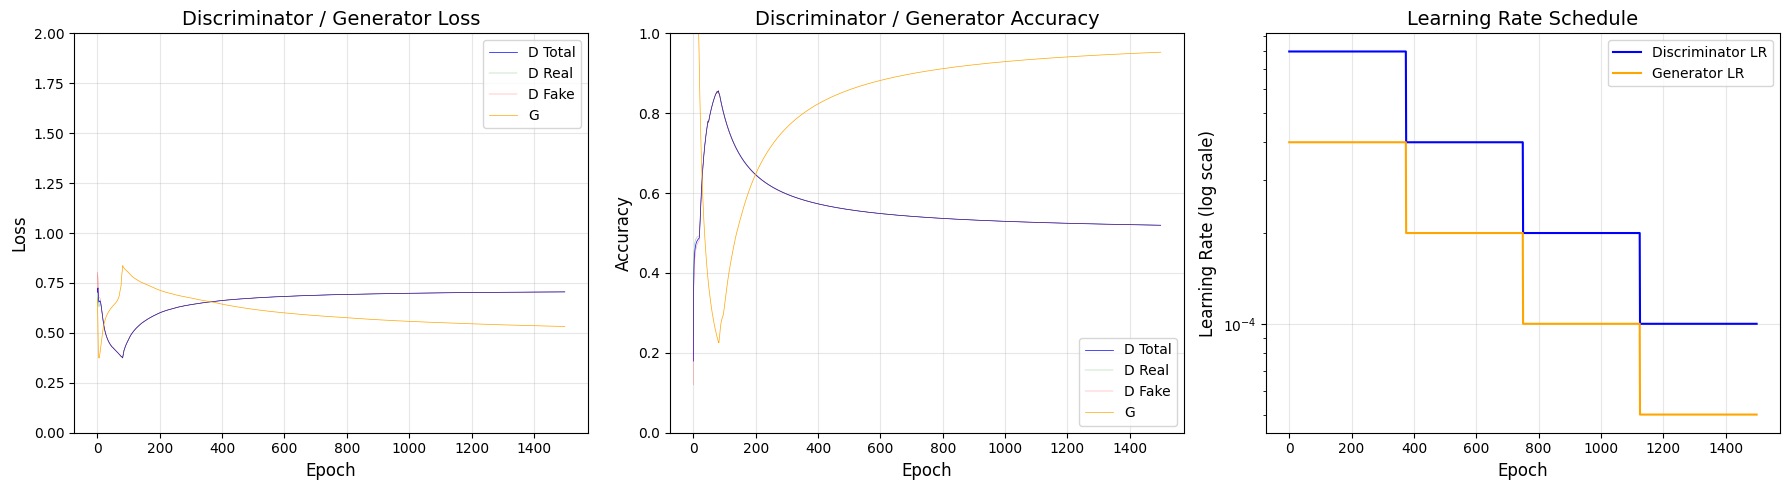

✓ Training summary saved to ../run/gan/0001_camel/training_summary.png


In [11]:
# =============================================================================
# TRAINING VISUALIZATION
# =============================================================================
# Creates a 3-panel figure showing:
# 1. Discriminator/Generator Loss vs Epoch
# 2. Discriminator/Generator Accuracy vs Epoch
# 3. Learning Rate Schedule (log scale)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# -----------------------------------------------------------------------------
# Plot 1: D/G Loss vs Epoch
# -----------------------------------------------------------------------------
ax1 = axes[0]
ax1.plot(
    [x[0] for x in gan.d_losses],
    color='blue', linewidth=0.5, label='D Total'
)
ax1.plot(
    [x[1] for x in gan.d_losses],
    color='green', linewidth=0.25, alpha=0.6, label='D Real'
)
ax1.plot(
    [x[2] for x in gan.d_losses],
    color='red', linewidth=0.25, alpha=0.6, label='D Fake'
)
ax1.plot(
    [x[0] for x in gan.g_losses],
    color='orange', linewidth=0.5, label='G'
)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Discriminator / Generator Loss', fontsize=14)
ax1.legend(loc='upper right')
ax1.set_ylim(0, 2)
ax1.grid(True, alpha=0.3)

# -----------------------------------------------------------------------------
# Plot 2: D/G Accuracy vs Epoch
# -----------------------------------------------------------------------------
ax2 = axes[1]
ax2.plot(
    [x[3] for x in gan.d_losses],
    color='blue', linewidth=0.5, label='D Total'
)
ax2.plot(
    [x[4] for x in gan.d_losses],
    color='green', linewidth=0.25, alpha=0.6, label='D Real'
)
ax2.plot(
    [x[5] for x in gan.d_losses],
    color='red', linewidth=0.25, alpha=0.6, label='D Fake'
)
ax2.plot(
    [x[1] for x in gan.g_losses],
    color='orange', linewidth=0.5, label='G'
)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Discriminator / Generator Accuracy', fontsize=14)
ax2.legend(loc='lower right')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

# -----------------------------------------------------------------------------
# Plot 3: Learning Rate vs Epoch (Log Scale)
# -----------------------------------------------------------------------------
ax3 = axes[2]
ax3.semilogy(
    gan.d_lr_history,
    color='blue', linewidth=1.5, label='Discriminator LR'
)
ax3.semilogy(
    gan.g_lr_history,
    color='orange', linewidth=1.5, label='Generator LR'
)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Learning Rate (log scale)', fontsize=12)
ax3.set_title('Learning Rate Schedule', fontsize=14)
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

# -----------------------------------------------------------------------------
# Finalize and Save
# -----------------------------------------------------------------------------
plt.tight_layout()
plt.savefig(
    os.path.join(RUN_FOLDER, 'training_summary.png'),
    dpi=200,
    bbox_inches='tight'
)
plt.show()

print(f"✓ Training summary saved to {RUN_FOLDER}/training_summary.png")

In [12]:
# =============================================================================
# TRAINING SUMMARY
# =============================================================================
# Print final training metrics

print(f"\n{'═' * 60}")
print("TRAINING COMPLETE")
print(f"{'═' * 60}")
print(f"  Epochs trained  : {gan.epoch}")
print(f"  Final D loss    : {gan.d_losses[-1][0]:.4f}")
print(f"  Final G loss    : {gan.g_losses[-1][0]:.4f}")
print(f"  Final D accuracy: {gan.d_losses[-1][3]:.4f}")
print(f"  Final G accuracy: {gan.g_losses[-1][1]:.4f}")
print(f"  Final D LR      : {gan.d_lr_history[-1]:.2e}")
print(f"  Final G LR      : {gan.g_lr_history[-1]:.2e}")
print(f"  Weights saved   : {RUN_FOLDER}/weights/")
print(f"{'═' * 60}")


════════════════════════════════════════════════════════════
TRAINING COMPLETE
════════════════════════════════════════════════════════════
  Epochs trained  : 1500
  Final D loss    : 0.7052
  Final G loss    : 0.5321
  Final D accuracy: 0.5195
  Final G accuracy: 0.9527
  Final D LR      : 1.00e-04
  Final G LR      : 5.00e-05
  Weights saved   : ../run/gan/0001_camel/weights/
════════════════════════════════════════════════════════════


## Cleanup

Finish W&B run and optionally restart kernel to release GPU memory.

In [13]:
# =============================================================================
# W&B CLEANUP
# =============================================================================
# Finish the W&B run to ensure all data is synced

wandb.finish()
print("✓ W&B run finished and synced")

d_acc,▆██▅▅▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
d_acc_fake,██▆▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
d_acc_real,█▆▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
d_loss,▃▁▁▂▄▆▆▆▆▇▇▇▇▇▇█████████████████████████
d_loss_fake,█▄▂▁▁▁▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
d_loss_real,▆▃▂▂▁▃▄▆▆▆▆▇▇▇▇▇████████████████████████
d_lr,███████▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
g_acc,▃▁▁▂▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
g_loss,▃██▇▇▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+1,...


✓ W&B run finished and synced


In [ ]:
# =============================================================================
# CLEANUP: Restart Kernel to Release GPU Memory
# =============================================================================
# TensorFlow/CUDA does not release GPU memory within a running Python process.
# Restarting the kernel is the only guaranteed way to free all GPU resources.
#
# ⚠️ WARNING: This will clear all variables and outputs!
# Only run after all work is complete and saved.

import IPython
print("Restarting kernel to release GPU memory...")
IPython.Application.instance().kernel.do_shutdown(restart=True)

Restarting kernel to release GPU memory...


{'status': 'ok', 'restart': True}

: 